<a href="https://colab.research.google.com/github/enesbol/NLP/blob/main/Fine-Tuning%20LLama%20using%20Parameter-Efficient%20Fine-Tuning%20and%204-bit%20Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful Links:

### 1- QLoRA: Efficient Finetuning of Quantized LLMs
https://arxiv.org/abs/2305.14314

### 2- PEFT(LoRA):
https://huggingface.co/docs/peft/conceptual_guides/lora

### 3- PEFT 
https://huggingface.co/blog/peft    

In short, PEFT approaches enable you to get performance comparable to full fine-tuning while only having a small number of trainable parameters.

Today, we are excited to introduce the 🤗 PEFT library, which provides the latest Parameter-Efficient Fine-tuning techniques seamlessly integrated with 🤗 Transformers and 🤗 Accelerate. This enables using the most popular and performant models from Transformers coupled with the simplicity and scalability of Accelerate. Below are the currently supported PEFT methods, with more coming soon:

- LoRA: LORA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS
- Prefix Tuning: P-Tuning v2: Prompt Tuning Can Be Comparable to Fine-tuning Universally Across Scales and Tasks
- Prompt Tuning: The Power of Scale for Parameter-Efficient Prompt Tuning
- P-Tuning: GPT Understands, Too

In [14]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [15]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [16]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "llama-2-7b-miniguanaco"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [22]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

In [23]:
dataset

Dataset({
    features: ['text'],
    num_rows: 1000
})

In [24]:
compute_dtype#

torch.float16

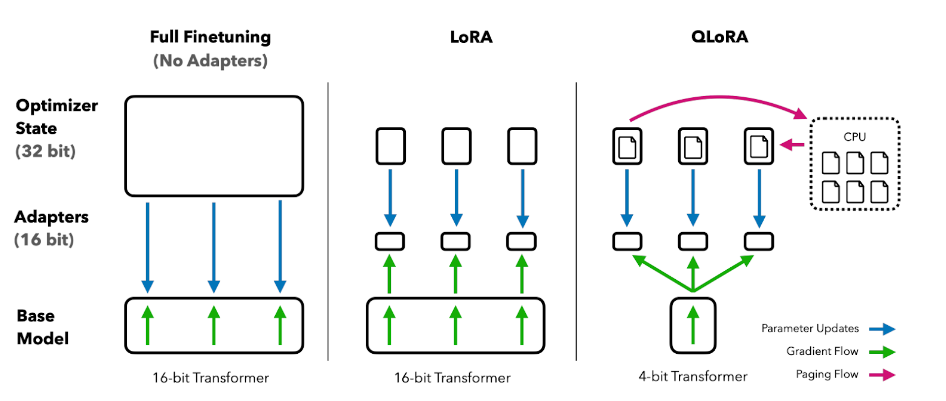

### Figure 1: Different finetuning methods and their memory requirements. QLORA improves over LoRA by quantizing the transformer model to 4-bit precision and using paged optimizers to handle memory" spikes.

- https://arxiv.org/pdf/2305.14314.pdf

In [25]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)
bnb_config

BitsAndBytesConfig {
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_type": "nf4",
  "load_in_4bit": true
}

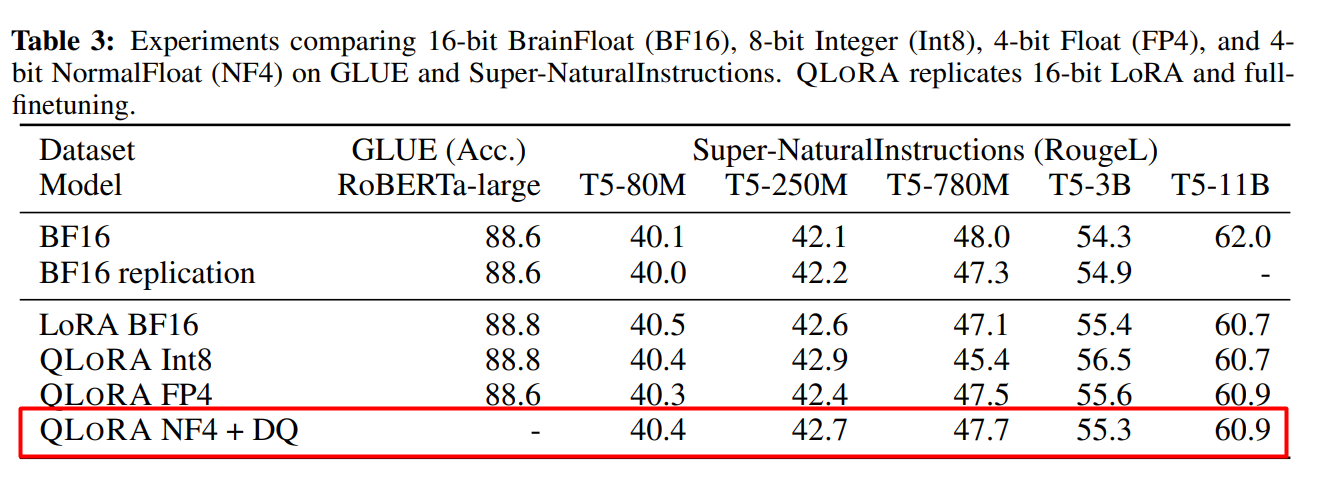

"Results are shown in Table 3. In both datasets, we observe that 16-bit, 8-bit, and 4-bit adapter methods replicate the performance of the fully
finetuned 16-bit baseline. This suggests that the performance lost
due to the imprecise quantization can be fully recovered through
adapter finetuning after quantization."

### Summary: 
Summary Our results consistently show that 4-bit QLORA with NF4 data type matches 16-bit full finetuning and 16-bit LoRA finetuning performance on academic benchmarks with wellestablished evaluation setups. We have also shown that NF4 is more effective than FP4 and that double quantization does not degrade performance. Combined, this forms compelling evidence that 4-bit QLORA tuning reliably yields results matching 16-bit methods.

4-bit QLORA = 16-bit

In [27]:
# Check GPU compatibility with bfloat16

# Activate 4-bit precision base model loading

use_4bit = True
# compute_dtype is torch.float16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

In [28]:
major

7

In [29]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1
model

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [30]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

tokenizer

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

LlamaTokenizerFast(name_or_path='NousResearch/Llama-2-7b-chat-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '</s>'}, clean_up_tokenization_spaces=False)

In [34]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=64, target_modules=None, lora_alpha=16, lora_dropout=0.1, fan_in_fan_out=False, bias='none', modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None)

In [36]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

training_arguments

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=True,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_stra

In [37]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,1.408400
50,1.665200
75,1.215700
100,1.446300
125,1.176800
150,1.366700
175,1.173600
200,1.467300
225,1.158000
250,1.541800


In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir results/runs

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

In [40]:
# Run text generation pipeline with our next model
prompt = "What is parameter efficient fine tuning ?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<s>[INST] What is parameter efficient fine tuning ? [/INST] Parameter efficient fine-tuning is a technique used in deep learning to reduce the number of parameters in a model while maintaining its performance. This is achieved by pruning or quantizing the model, which reduces the number of computations required to perform the model's tasks.

There are several techniques used in parameter efficient fine-tuning, including:

1. Pruning: This involves removing redundant or unnecessary neurons and connections in the model. This can be done using various pruning algorithms, such as magnitude pruning or weight pruning.
2. Quantization: This involves reducing the precision of the model's weights and activations from floating-point numbers to integers. This can be done using various quantization algorithms, such as binary or ternary quantization.
3. Knowledge distillation: This involves training a smaller model to mimic the behavior of


In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

19965

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
!huggingface-cli login

model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mlabonne/llama-2-7b-miniguanaco/commit/c81a32fd0b4d39e252326e639d63e75aa68c9a4a', commit_message='Upload tokenizer', commit_description='', oid='c81a32fd0b4d39e252326e639d63e75aa68c9a4a', pr_url=None, pr_revision=None, pr_num=None)